# Training Skript for Image based WHO grade regression network

    1. Load necessary data
    2. Initialize model
    3. Training loop

## 1. Load necessary data

In [ ]:
%load_ext autoreload
%autoreload 2

import pickle
import RegressionDataSet4
import torch 

torch.cuda.empty_cache()

annotation_dict = pickle.load(open("annotation_dict2.p","rb"))

In [2]:
keys_to_discard = list()
keys_for_training = list()
keys_excluded_testset=0
ldfnummer_exclude = []
testset_exclude = pickle.load(open('Testset_List.p','rb'))
for key in annotation_dict:
    if key in testset_exclude:
        ldfnummer_exclude += [annotation_dict[key]['lfd_number']]

for key in annotation_dict:
    try:
        if (annotation_dict[key]['mitotic_count'] >= 0) and (annotation_dict[key]['lfd_number'] not in ldfnummer_exclude):
            keys_for_training.append(key)
        else:
            keys_to_discard.append(key)
    except KeyError:
        keys_to_discard.append(key)

import numpy as np
keys_excluded_testset,
ldfnummer_exclude = np.unique(ldfnummer_exclude)
ldfnummer_exclude
len(ldfnummer_exclude)

In [6]:
tmp = dict()
for key in annotation_dict:
    lfd_number = annotation_dict[key]['lfd_number']
    if (lfd_number in ldfnummer_exclude):
        continue
    if lfd_number not in tmp:
        tmp[lfd_number] = dict()
        tmp[lfd_number]['file'] = key
        tmp[lfd_number]['who_grade'] = annotation_dict[key]['who_grade']
        # bei Fällen, bei denen der MC = 0 ist existiert kein Eintrag für 'mitotic_count'
        try:
            tmp[lfd_number]['mitotic_count'] = annotation_dict[key]['mitotic_count']
        except KeyError:
            tmp[lfd_number]['mitotic_count'] = 0
    try:
        if tmp[lfd_number]['mitotic_count'] < annotation_dict[key]['mitotic_count']:
            tmp[lfd_number]['file'] = key
            tmp[lfd_number]['who_grade'] = annotation_dict[key]['who_grade']
            tmp[lfd_number]['mitotic_count'] = annotation_dict[key]['mitotic_count']
    except KeyError:
        continue

patients = tmp
import random

random.seed(2)
# 15 % validation data
val_numbers = [lfd_number for lfd_number in random.sample(patients.keys(),54)]
val_keys = [patients[lfd_number]['file'] for lfd_number in val_numbers]

train_numbers = [lfd_number for lfd_number in patients if lfd_number not in val_numbers]
train_keys = [patients[lfd_number]['file'] for lfd_number in train_numbers]




In [8]:
from torchvision import transforms
from torch.utils.data import DataLoader
import random


path_to_wsis = ""

transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.8249, 0.5482, 0.7211),(0.0573, 0.0988, 0.0595))])

batch_size = 8

train_data = RegressionDataSet4.WhoRegressionDataSet(path_to_wsis,train_keys,annotation_dict,1000,transform,level = 0)
train_loader = DataLoader(train_data, batch_size = batch_size, collate_fn=train_data.collate_fn)

val_data = RegressionDataSet4.WhoRegressionDataSet(path_to_wsis,val_keys,annotation_dict,100,transform,level = 0)
val_loader = DataLoader(val_data, batch_size = batch_size, collate_fn=val_data.collate_fn)

data_loaders = {
    'train' : train_loader,
    'val' : val_loader,
}

100% (287 of 287) |######################| Elapsed Time: 0:00:19 Time:  0:00:19
100% (54 of 54) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


## 2. Initialize model

In [9]:
import torchvision
import torch
import Model1
from torch import nn, optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = Model1.RegressionModel()
model.to(device)

RegressionModel(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats

## 3. Training loop

In [10]:
from tqdm import tqdm

def train_loop(train_loader, model, loss_fn, optimizer):
    running_loss = 0
    size = train_loader.dataset.pseudo_epoch_length
    for  batch, (X,y) in enumerate(train_loader):
        # Image
        X = X.to(device)
        # who grade
        y = y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        if batch % 10 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"Current batch loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    running_loss /= len(train_loader)
    print(f"Mean Train Loss: {running_loss:.5f}")
    return running_loss 
  
            
def test_loop(test_loader, model, loss_fn):
    print("Validation")
    size = len(test_loader)
    test_loss = 0

    with torch.no_grad():
        for X,y in tqdm(test_loader):
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
    test_loss /= size
    print(f"Avg loss: {test_loss:>8f} \n")
    return test_loss

In [11]:
loss_fn = torch.nn.MSELoss(reduction = 'mean')
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode = 'min', factor = 0.1, patience = 5, verbose=True)

In [13]:
#optimizer.param_groups[0]['lr'] = 0.01
epochs = 5
val_losses = list()
train_losses = list()
weights = []
biases = []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss= train_loop(train_loader, model, loss_fn, optimizer)
    val_loss = test_loop(val_loader, model, loss_fn)
    
    # model selection
    if t == 0:
        best_loss = val_loss
    else:
        if val_loss < best_loss:
            best_model = model.state_dict()
            best_loss = val_loss
            
    weights.append(model.fc2.weight.data.cpu().numpy()[0][0])
    biases.append(model.fc2.bias.data.cpu().numpy())
    scheduler.step(val_loss)
    val_losses.append(val_loss)
    train_losses.append(train_loss)
print("Done!")

Epoch 1
-------------------------------
Current batch loss: 6.472780  [    0/ 1000]
Current batch loss: 1.475167  [   80/ 1000]
Current batch loss: 1.186334  [  160/ 1000]
Current batch loss: 0.643188  [  240/ 1000]
Current batch loss: 0.423618  [  320/ 1000]
Current batch loss: 0.192283  [  400/ 1000]
Current batch loss: 0.362189  [  480/ 1000]
Current batch loss: 0.276175  [  560/ 1000]
Current batch loss: 0.496211  [  640/ 1000]
Current batch loss: 0.374200  [  720/ 1000]
Current batch loss: 0.125635  [  800/ 1000]
Current batch loss: 0.343314  [  880/ 1000]
Current batch loss: 0.229178  [  960/ 1000]


  0%|          | 0/13 [00:00<?, ?it/s]

Mean Train Loss: 0.65452
Validation


100%|██████████| 13/13 [00:13<00:00,  1.07s/it]


Avg loss: 0.605490 

Epoch 2
-------------------------------
Current batch loss: 0.605480  [    0/ 1000]
Current batch loss: 1.213721  [   80/ 1000]
Current batch loss: 0.188971  [  160/ 1000]
Current batch loss: 0.687769  [  240/ 1000]
Current batch loss: 0.305595  [  320/ 1000]
Current batch loss: 0.386079  [  400/ 1000]
Current batch loss: 0.044732  [  480/ 1000]
Current batch loss: 0.587330  [  560/ 1000]
Current batch loss: 0.142462  [  640/ 1000]
Current batch loss: 0.444643  [  720/ 1000]
Current batch loss: 0.268837  [  800/ 1000]
Current batch loss: 0.400498  [  880/ 1000]
Current batch loss: 0.352809  [  960/ 1000]


  0%|          | 0/13 [00:00<?, ?it/s]

Mean Train Loss: 0.33802
Validation


100%|██████████| 13/13 [00:13<00:00,  1.00s/it]


Avg loss: 0.600341 

Epoch 3
-------------------------------
Current batch loss: 0.211684  [    0/ 1000]
Current batch loss: 0.263310  [   80/ 1000]
Current batch loss: 0.250999  [  160/ 1000]
Current batch loss: 0.406072  [  240/ 1000]
Current batch loss: 0.241749  [  320/ 1000]
Current batch loss: 0.329474  [  400/ 1000]
Current batch loss: 0.122497  [  480/ 1000]
Current batch loss: 0.306828  [  560/ 1000]
Current batch loss: 0.242437  [  640/ 1000]
Current batch loss: 0.101161  [  720/ 1000]
Current batch loss: 0.379384  [  800/ 1000]
Current batch loss: 0.181775  [  880/ 1000]
Current batch loss: 0.312521  [  960/ 1000]


  0%|          | 0/13 [00:00<?, ?it/s]

Mean Train Loss: 0.29180
Validation


100%|██████████| 13/13 [00:13<00:00,  1.04s/it]


Avg loss: 0.544478 

Epoch 4
-------------------------------
Current batch loss: 0.161392  [    0/ 1000]
Current batch loss: 0.148482  [   80/ 1000]
Current batch loss: 0.428092  [  160/ 1000]
Current batch loss: 0.082883  [  240/ 1000]
Current batch loss: 0.412731  [  320/ 1000]
Current batch loss: 0.203050  [  400/ 1000]
Current batch loss: 0.166464  [  480/ 1000]
Current batch loss: 0.499765  [  560/ 1000]
Current batch loss: 0.139609  [  640/ 1000]
Current batch loss: 0.148998  [  720/ 1000]
Current batch loss: 0.281727  [  800/ 1000]
Current batch loss: 0.136762  [  880/ 1000]
Current batch loss: 0.233076  [  960/ 1000]


  0%|          | 0/13 [00:00<?, ?it/s]

Mean Train Loss: 0.27342
Validation


100%|██████████| 13/13 [00:12<00:00,  1.05it/s]


Avg loss: 0.481349 

Epoch 5
-------------------------------
Current batch loss: 0.248616  [    0/ 1000]
Current batch loss: 0.374771  [   80/ 1000]
Current batch loss: 0.176602  [  160/ 1000]
Current batch loss: 0.308610  [  240/ 1000]
Current batch loss: 0.337643  [  320/ 1000]
Current batch loss: 0.190720  [  400/ 1000]
Current batch loss: 0.089589  [  480/ 1000]
Current batch loss: 0.228322  [  560/ 1000]
Current batch loss: 0.304207  [  640/ 1000]
Current batch loss: 0.115131  [  720/ 1000]
Current batch loss: 0.076848  [  800/ 1000]
Current batch loss: 0.506837  [  880/ 1000]
Current batch loss: 0.194924  [  960/ 1000]


  0%|          | 0/13 [00:00<?, ?it/s]

Mean Train Loss: 0.25549
Validation


100%|██████████| 13/13 [00:13<00:00,  1.00s/it]

Avg loss: 0.642378 

Done!


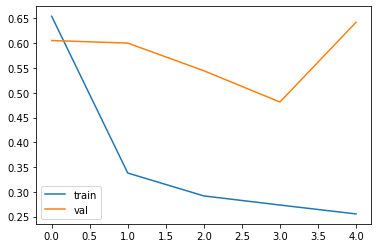

In [14]:
import matplotlib.pyplot as plt
plt.plot(train_losses,label='train')
plt.plot(val_losses,label='val')
plt.legend()

In [15]:
epochs = 10

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss= train_loop(train_loader, model, loss_fn, optimizer)
    val_loss = test_loop(val_loader, model, loss_fn)
    
    # model selection
    if val_loss < best_loss:
        best_model = model.state_dict()
        best_loss = val_loss
            
    weights.append(model.fc2.weight.data.cpu().numpy()[0][0])
    biases.append(model.fc2.bias.data.cpu().numpy())
    scheduler.step(val_loss)
    val_losses.append(val_loss)
    train_losses.append(train_loss)
print("Done!")

Epoch 1
-------------------------------
Current batch loss: 0.331874  [    0/ 1000]
Current batch loss: 0.214239  [   80/ 1000]
Current batch loss: 0.057308  [  160/ 1000]
Current batch loss: 0.107044  [  240/ 1000]
Current batch loss: 0.145065  [  320/ 1000]
Current batch loss: 0.082815  [  400/ 1000]
Current batch loss: 0.188539  [  480/ 1000]
Current batch loss: 0.244258  [  560/ 1000]
Current batch loss: 0.363318  [  640/ 1000]
Current batch loss: 0.121214  [  720/ 1000]
Current batch loss: 0.243545  [  800/ 1000]
Current batch loss: 0.239109  [  880/ 1000]
Current batch loss: 0.175951  [  960/ 1000]


  0%|          | 0/13 [00:00<?, ?it/s]

Mean Train Loss: 0.25875
Validation


100%|██████████| 13/13 [00:12<00:00,  1.04it/s]


Avg loss: 0.624542 

Epoch 2
-------------------------------
Current batch loss: 0.171885  [    0/ 1000]
Current batch loss: 0.353742  [   80/ 1000]
Current batch loss: 0.151591  [  160/ 1000]
Current batch loss: 0.146471  [  240/ 1000]
Current batch loss: 0.568895  [  320/ 1000]
Current batch loss: 0.241644  [  400/ 1000]
Current batch loss: 0.371757  [  480/ 1000]
Current batch loss: 0.194937  [  560/ 1000]
Current batch loss: 0.368332  [  640/ 1000]
Current batch loss: 0.063845  [  720/ 1000]
Current batch loss: 0.028442  [  800/ 1000]
Current batch loss: 0.219542  [  880/ 1000]
Current batch loss: 0.058845  [  960/ 1000]


  0%|          | 0/13 [00:00<?, ?it/s]

Mean Train Loss: 0.27427
Validation


100%|██████████| 13/13 [00:12<00:00,  1.01it/s]


Avg loss: 0.787537 

Epoch 3
-------------------------------
Current batch loss: 0.597098  [    0/ 1000]
Current batch loss: 0.227816  [   80/ 1000]
Current batch loss: 0.360147  [  160/ 1000]
Current batch loss: 0.286803  [  240/ 1000]
Current batch loss: 0.322165  [  320/ 1000]
Current batch loss: 0.168725  [  400/ 1000]
Current batch loss: 0.188190  [  480/ 1000]
Current batch loss: 0.145475  [  560/ 1000]
Current batch loss: 0.371719  [  640/ 1000]
Current batch loss: 0.215395  [  720/ 1000]
Current batch loss: 0.273489  [  800/ 1000]
Current batch loss: 0.754472  [  880/ 1000]
Current batch loss: 0.132528  [  960/ 1000]


  0%|          | 0/13 [00:00<?, ?it/s]

Mean Train Loss: 0.26746
Validation


100%|██████████| 13/13 [00:12<00:00,  1.06it/s]


Avg loss: 0.615786 

Epoch 4
-------------------------------
Current batch loss: 0.104346  [    0/ 1000]
Current batch loss: 0.283244  [   80/ 1000]
Current batch loss: 0.168727  [  160/ 1000]
Current batch loss: 0.236454  [  240/ 1000]
Current batch loss: 0.056651  [  320/ 1000]
Current batch loss: 0.358896  [  400/ 1000]
Current batch loss: 0.154727  [  480/ 1000]
Current batch loss: 0.187639  [  560/ 1000]
Current batch loss: 0.100710  [  640/ 1000]
Current batch loss: 0.266782  [  720/ 1000]
Current batch loss: 0.205245  [  800/ 1000]
Current batch loss: 0.158860  [  880/ 1000]
Current batch loss: 0.124350  [  960/ 1000]


  0%|          | 0/13 [00:00<?, ?it/s]

Mean Train Loss: 0.26539
Validation


100%|██████████| 13/13 [00:12<00:00,  1.05it/s]


Avg loss: 0.664568 

Epoch 5
-------------------------------
Current batch loss: 0.387041  [    0/ 1000]
Current batch loss: 0.483453  [   80/ 1000]
Current batch loss: 0.860127  [  160/ 1000]
Current batch loss: 0.082173  [  240/ 1000]
Current batch loss: 0.154857  [  320/ 1000]
Current batch loss: 0.168963  [  400/ 1000]
Current batch loss: 0.093562  [  480/ 1000]
Current batch loss: 0.224732  [  560/ 1000]
Current batch loss: 0.259751  [  640/ 1000]
Current batch loss: 0.281336  [  720/ 1000]
Current batch loss: 0.177082  [  800/ 1000]
Current batch loss: 0.182865  [  880/ 1000]
Current batch loss: 0.249461  [  960/ 1000]


  0%|          | 0/13 [00:00<?, ?it/s]

Mean Train Loss: 0.28163
Validation


100%|██████████| 13/13 [00:12<00:00,  1.01it/s]


Avg loss: 0.514718 

Epoch    10: reducing learning rate of group 0 to 1.0000e-05.
Epoch 6
-------------------------------
Current batch loss: 0.038906  [    0/ 1000]
Current batch loss: 0.211997  [   80/ 1000]
Current batch loss: 0.047653  [  160/ 1000]
Current batch loss: 0.324134  [  240/ 1000]
Current batch loss: 0.171356  [  320/ 1000]
Current batch loss: 0.183281  [  400/ 1000]
Current batch loss: 0.219954  [  480/ 1000]
Current batch loss: 0.208365  [  560/ 1000]
Current batch loss: 0.246887  [  640/ 1000]
Current batch loss: 0.385627  [  720/ 1000]
Current batch loss: 0.187998  [  800/ 1000]
Current batch loss: 0.185034  [  880/ 1000]
Current batch loss: 0.056505  [  960/ 1000]


  0%|          | 0/13 [00:00<?, ?it/s]

Mean Train Loss: 0.22418
Validation


100%|██████████| 13/13 [00:13<00:00,  1.03s/it]


Avg loss: 0.415296 

Epoch 7
-------------------------------
Current batch loss: 0.148605  [    0/ 1000]
Current batch loss: 0.408609  [   80/ 1000]
Current batch loss: 0.299070  [  160/ 1000]
Current batch loss: 0.093075  [  240/ 1000]
Current batch loss: 0.212871  [  320/ 1000]
Current batch loss: 0.214657  [  400/ 1000]
Current batch loss: 0.182752  [  480/ 1000]
Current batch loss: 0.104221  [  560/ 1000]
Current batch loss: 0.168150  [  640/ 1000]
Current batch loss: 0.144568  [  720/ 1000]
Current batch loss: 0.247473  [  800/ 1000]
Current batch loss: 0.136735  [  880/ 1000]
Current batch loss: 0.055806  [  960/ 1000]


  0%|          | 0/13 [00:00<?, ?it/s]

Mean Train Loss: 0.21728
Validation


100%|██████████| 13/13 [00:12<00:00,  1.00it/s]


Avg loss: 0.551573 

Epoch 8
-------------------------------
Current batch loss: 0.256186  [    0/ 1000]
Current batch loss: 0.107450  [   80/ 1000]
Current batch loss: 0.074915  [  160/ 1000]
Current batch loss: 0.158818  [  240/ 1000]
Current batch loss: 0.268889  [  320/ 1000]
Current batch loss: 0.229481  [    0/ 1000]
Current batch loss: 0.184725  [   80/ 1000]
Current batch loss: 0.154326  [  160/ 1000]
Current batch loss: 0.185839  [  240/ 1000]
Current batch loss: 0.196068  [  320/ 1000]
Current batch loss: 0.294914  [  400/ 1000]
Current batch loss: 0.661087  [  480/ 1000]
Current batch loss: 0.078514  [  560/ 1000]
Current batch loss: 0.093972  [  640/ 1000]
Current batch loss: 0.218662  [  720/ 1000]
Current batch loss: 0.082720  [  800/ 1000]
Current batch loss: 0.169186  [  880/ 1000]
Current batch loss: 0.189753  [  960/ 1000]


  0%|          | 0/13 [00:00<?, ?it/s]

Mean Train Loss: 0.21110
Validation


100%|██████████| 13/13 [00:13<00:00,  1.01s/it]


Avg loss: 0.437122 

Epoch 10
-------------------------------
Current batch loss: 0.263721  [    0/ 1000]
Current batch loss: 0.330033  [   80/ 1000]
Current batch loss: 0.169786  [  160/ 1000]
Current batch loss: 0.168898  [  240/ 1000]
Current batch loss: 0.427763  [  320/ 1000]
Current batch loss: 0.258093  [  400/ 1000]
Current batch loss: 0.272748  [  480/ 1000]
Current batch loss: 0.340231  [  560/ 1000]
Current batch loss: 0.299740  [  640/ 1000]
Current batch loss: 0.204984  [  720/ 1000]
Current batch loss: 0.118027  [  800/ 1000]
Current batch loss: 0.610205  [  880/ 1000]
Current batch loss: 0.090547  [  960/ 1000]


  0%|          | 0/13 [00:00<?, ?it/s]

Mean Train Loss: 0.20686
Validation


100%|██████████| 13/13 [00:14<00:00,  1.09s/it]

Avg loss: 0.503687 

Done!


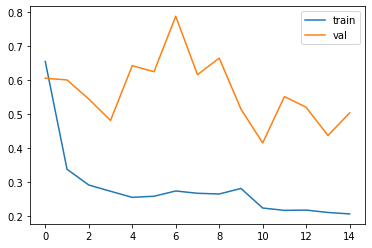

In [16]:
import matplotlib.pyplot as plt
plt.plot(train_losses,label='train')
plt.plot(val_losses,label='val')
plt.legend()

In [17]:
epochs = 20

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss= train_loop(train_loader, model, loss_fn, optimizer)
    val_loss = test_loop(val_loader, model, loss_fn)
    
    # model selection
    if val_loss < best_loss:
        best_model = model.state_dict()
        best_loss = val_loss
            
    weights.append(model.fc2.weight.data.cpu().numpy()[0][0])
    biases.append(model.fc2.bias.data.cpu().numpy())
    scheduler.step(val_loss)
    val_losses.append(val_loss)
    train_losses.append(train_loss)
print("Done!")

Epoch 1
-------------------------------
Current batch loss: 0.346740  [    0/ 1000]
Current batch loss: 0.177267  [   80/ 1000]
Current batch loss: 0.319606  [  160/ 1000]
Current batch loss: 0.143646  [  240/ 1000]
Current batch loss: 0.199264  [  320/ 1000]
Current batch loss: 0.071349  [  400/ 1000]
Current batch loss: 0.191098  [  480/ 1000]
Current batch loss: 0.402980  [  560/ 1000]
Current batch loss: 0.257464  [  640/ 1000]
Current batch loss: 0.550210  [  720/ 1000]
Current batch loss: 0.275786  [  800/ 1000]
Current batch loss: 0.116548  [  880/ 1000]
Current batch loss: 0.093293  [  960/ 1000]


  0%|          | 0/13 [00:00<?, ?it/s]

Mean Train Loss: 0.21488
Validation


100%|██████████| 13/13 [00:13<00:00,  1.00s/it]


Avg loss: 0.583516 

Epoch 2
-------------------------------
Current batch loss: 0.059788  [    0/ 1000]
Current batch loss: 0.101904  [   80/ 1000]
Current batch loss: 0.124750  [  160/ 1000]
Current batch loss: 0.028722  [  240/ 1000]
Current batch loss: 0.328227  [  320/ 1000]
Current batch loss: 0.142246  [  400/ 1000]
Current batch loss: 0.113529  [  480/ 1000]
Current batch loss: 0.253307  [  560/ 1000]
Current batch loss: 0.148124  [  640/ 1000]
Current batch loss: 0.078226  [  720/ 1000]
Current batch loss: 0.271736  [  800/ 1000]
Current batch loss: 0.329333  [  880/ 1000]
Current batch loss: 0.447754  [  960/ 1000]


  0%|          | 0/13 [00:00<?, ?it/s]

Mean Train Loss: 0.21394
Validation


100%|██████████| 13/13 [00:13<00:00,  1.01s/it]


Avg loss: 0.501232 

Epoch    17: reducing learning rate of group 0 to 1.0000e-06.
Epoch 3
-------------------------------
Current batch loss: 0.325653  [    0/ 1000]
Current batch loss: 0.152541  [   80/ 1000]
Current batch loss: 0.139700  [  160/ 1000]
Current batch loss: 0.477150  [  240/ 1000]
Current batch loss: 0.266829  [  320/ 1000]
Current batch loss: 0.120775  [  400/ 1000]
Current batch loss: 0.136282  [  480/ 1000]
Current batch loss: 0.164206  [  560/ 1000]
Current batch loss: 0.220858  [  640/ 1000]
Current batch loss: 0.234860  [  720/ 1000]
Current batch loss: 0.104862  [  800/ 1000]
Current batch loss: 0.118290  [  880/ 1000]
Current batch loss: 0.084036  [  960/ 1000]


  0%|          | 0/13 [00:00<?, ?it/s]

Mean Train Loss: 0.22590
Validation


100%|██████████| 13/13 [00:11<00:00,  1.09it/s]


Avg loss: 0.464767 

Epoch 4
-------------------------------
Current batch loss: 0.090510  [    0/ 1000]
Current batch loss: 0.108082  [   80/ 1000]
Current batch loss: 0.246568  [  160/ 1000]
Current batch loss: 0.401080  [  240/ 1000]
Current batch loss: 0.385448  [  320/ 1000]
Current batch loss: 0.214041  [  400/ 1000]
Current batch loss: 0.310069  [  480/ 1000]
Current batch loss: 0.313124  [  560/ 1000]
Current batch loss: 0.022800  [  640/ 1000]
Current batch loss: 0.141588  [  720/ 1000]
Current batch loss: 0.206646  [  800/ 1000]
Current batch loss: 0.393137  [  880/ 1000]
Current batch loss: 0.344884  [  960/ 1000]


  0%|          | 0/13 [00:00<?, ?it/s]

Mean Train Loss: 0.22002
Validation


100%|██████████| 13/13 [00:13<00:00,  1.02s/it]


Avg loss: 0.507349 

Epoch 5
-------------------------------
Current batch loss: 0.131924  [    0/ 1000]
Current batch loss: 0.193462  [   80/ 1000]
Current batch loss: 0.062798  [  160/ 1000]
Current batch loss: 0.339756  [  240/ 1000]
Current batch loss: 0.327427  [  320/ 1000]
Current batch loss: 0.304956  [  400/ 1000]
Current batch loss: 0.135213  [  480/ 1000]
Current batch loss: 0.111336  [  560/ 1000]
Current batch loss: 0.377430  [  640/ 1000]
Current batch loss: 0.200320  [  720/ 1000]
Current batch loss: 0.049743  [  800/ 1000]
Current batch loss: 0.101816  [  880/ 1000]
Current batch loss: 0.216726  [  960/ 1000]


  0%|          | 0/13 [00:00<?, ?it/s]

Mean Train Loss: 0.21448
Validation


100%|██████████| 13/13 [00:13<00:00,  1.03s/it]


Avg loss: 0.566577 

Epoch 6
-------------------------------
Current batch loss: 0.139595  [    0/ 1000]
Current batch loss: 0.053543  [   80/ 1000]
Current batch loss: 0.095891  [  160/ 1000]
Current batch loss: 0.353868  [  240/ 1000]
Current batch loss: 0.261270  [  320/ 1000]
Current batch loss: 0.236735  [  400/ 1000]
Current batch loss: 0.072008  [  480/ 1000]
Current batch loss: 0.238295  [  560/ 1000]
Current batch loss: 0.587173  [  640/ 1000]
Current batch loss: 0.254147  [  720/ 1000]
Current batch loss: 0.121629  [  800/ 1000]
Current batch loss: 0.375392  [  880/ 1000]
Current batch loss: 0.117773  [  960/ 1000]


  0%|          | 0/13 [00:00<?, ?it/s]

Mean Train Loss: 0.22282
Validation


100%|██████████| 13/13 [00:09<00:00,  1.44it/s]


Avg loss: 0.497866 

Epoch 7
-------------------------------
Current batch loss: 0.197858  [    0/ 1000]
Current batch loss: 0.062346  [   80/ 1000]
Current batch loss: 0.158804  [  160/ 1000]
Current batch loss: 0.530160  [  240/ 1000]
Current batch loss: 0.257846  [  320/ 1000]
Current batch loss: 0.037238  [  400/ 1000]
Current batch loss: 0.296542  [  480/ 1000]
Current batch loss: 0.102970  [  560/ 1000]
Current batch loss: 0.193812  [  640/ 1000]
Current batch loss: 0.215404  [  720/ 1000]
Current batch loss: 0.084812  [  800/ 1000]
Current batch loss: 0.516324  [  880/ 1000]
Current batch loss: 0.138002  [  960/ 1000]


  0%|          | 0/13 [00:00<?, ?it/s]

Mean Train Loss: 0.22480
Validation


100%|██████████| 13/13 [00:09<00:00,  1.37it/s]


Avg loss: 0.559511 

Epoch 8
-------------------------------
Current batch loss: 0.057525  [    0/ 1000]
Current batch loss: 0.226017  [   80/ 1000]
Current batch loss: 0.193537  [  160/ 1000]
Current batch loss: 0.192605  [  240/ 1000]
Current batch loss: 0.914087  [  320/ 1000]
Current batch loss: 0.345675  [  400/ 1000]
Current batch loss: 0.246480  [  480/ 1000]
Current batch loss: 0.067217  [  560/ 1000]
Current batch loss: 0.126222  [  640/ 1000]
Current batch loss: 0.240933  [  720/ 1000]
Current batch loss: 0.485690  [  800/ 1000]
Current batch loss: 0.069978  [  880/ 1000]
Current batch loss: 0.131554  [  960/ 1000]


  0%|          | 0/13 [00:00<?, ?it/s]

Mean Train Loss: 0.22802
Validation


100%|██████████| 13/13 [00:09<00:00,  1.43it/s]


Avg loss: 0.557913 

Epoch    23: reducing learning rate of group 0 to 1.0000e-07.
Epoch 9
-------------------------------
Current batch loss: 0.199892  [    0/ 1000]
Current batch loss: 0.081403  [   80/ 1000]
Current batch loss: 0.198748  [  160/ 1000]
Current batch loss: 0.775297  [  240/ 1000]
Current batch loss: 0.201238  [  320/ 1000]
Current batch loss: 0.087779  [  400/ 1000]
Current batch loss: 0.056784  [  480/ 1000]
Current batch loss: 0.327971  [  560/ 1000]
Current batch loss: 0.288547  [  640/ 1000]
Current batch loss: 0.268695  [  720/ 1000]
Current batch loss: 0.245281  [  800/ 1000]
Current batch loss: 0.356510  [  880/ 1000]
Current batch loss: 0.114501  [  960/ 1000]


  0%|          | 0/13 [00:00<?, ?it/s]

Mean Train Loss: 0.22182
Validation


100%|██████████| 13/13 [00:09<00:00,  1.36it/s]


Avg loss: 0.558106 

Epoch 10
-------------------------------
Current batch loss: 0.192417  [    0/ 1000]
Current batch loss: 0.187658  [   80/ 1000]
Current batch loss: 0.175010  [  160/ 1000]
Current batch loss: 0.404162  [  240/ 1000]
Current batch loss: 0.139640  [  320/ 1000]
Current batch loss: 0.265420  [  400/ 1000]
Current batch loss: 0.223840  [  480/ 1000]
Current batch loss: 0.193526  [  560/ 1000]
Current batch loss: 0.143630  [  640/ 1000]
Current batch loss: 0.283343  [  720/ 1000]
Current batch loss: 0.389888  [  800/ 1000]
Current batch loss: 0.162542  [  880/ 1000]
Current batch loss: 0.115363  [  960/ 1000]


  0%|          | 0/13 [00:00<?, ?it/s]

Mean Train Loss: 0.22339
Validation


100%|██████████| 13/13 [00:09<00:00,  1.40it/s]


Avg loss: 0.460668 

Epoch 11
-------------------------------
Current batch loss: 0.231625  [    0/ 1000]
Current batch loss: 0.213367  [   80/ 1000]
Current batch loss: 0.153876  [  160/ 1000]
Current batch loss: 0.067900  [  240/ 1000]
Current batch loss: 0.436399  [  320/ 1000]
Current batch loss: 0.298352  [  400/ 1000]
Current batch loss: 0.134561  [  480/ 1000]
Current batch loss: 0.309293  [  560/ 1000]
Current batch loss: 0.212457  [  640/ 1000]
Current batch loss: 0.180101  [  720/ 1000]
Current batch loss: 0.050694  [  800/ 1000]
Current batch loss: 0.170492  [  880/ 1000]
Current batch loss: 0.154940  [  960/ 1000]


  0%|          | 0/13 [00:00<?, ?it/s]

Mean Train Loss: 0.19930
Validation


100%|██████████| 13/13 [00:08<00:00,  1.45it/s]


Avg loss: 0.639658 

Epoch 12
-------------------------------
Current batch loss: 0.130010  [    0/ 1000]
Current batch loss: 0.178845  [   80/ 1000]
Current batch loss: 0.046869  [  160/ 1000]
Current batch loss: 0.428842  [  240/ 1000]
Current batch loss: 0.084191  [  320/ 1000]
Current batch loss: 0.239277  [  400/ 1000]
Current batch loss: 0.283049  [  480/ 1000]
Current batch loss: 0.192538  [  560/ 1000]
Current batch loss: 0.446898  [  640/ 1000]
Current batch loss: 0.280700  [  720/ 1000]
Current batch loss: 0.152931  [  800/ 1000]
Current batch loss: 0.156438  [  880/ 1000]
Current batch loss: 0.060343  [  960/ 1000]


  0%|          | 0/13 [00:00<?, ?it/s]

Mean Train Loss: 0.24937
Validation


100%|██████████| 13/13 [00:09<00:00,  1.42it/s]


Avg loss: 0.629039 

Epoch 13
-------------------------------
Current batch loss: 0.194067  [    0/ 1000]
Current batch loss: 0.151069  [   80/ 1000]
Current batch loss: 0.335672  [  160/ 1000]
Current batch loss: 0.227649  [  240/ 1000]
Current batch loss: 0.073730  [  320/ 1000]
Current batch loss: 0.476954  [  400/ 1000]
Current batch loss: 0.271142  [  480/ 1000]
Current batch loss: 0.108584  [  560/ 1000]
Current batch loss: 0.401011  [  640/ 1000]
Current batch loss: 0.137771  [  720/ 1000]
Current batch loss: 0.343395  [  800/ 1000]
Current batch loss: 0.220747  [  880/ 1000]
Current batch loss: 0.083886  [  960/ 1000]


  0%|          | 0/13 [00:00<?, ?it/s]

Mean Train Loss: 0.20014
Validation


100%|██████████| 13/13 [00:08<00:00,  1.45it/s]


Avg loss: 0.566344 

Epoch 14
-------------------------------
Current batch loss: 0.131650  [    0/ 1000]
Current batch loss: 0.177703  [   80/ 1000]
Current batch loss: 0.216358  [  160/ 1000]
Current batch loss: 0.086375  [  240/ 1000]
Current batch loss: 0.197310  [  320/ 1000]
Current batch loss: 0.376826  [  400/ 1000]
Current batch loss: 0.213475  [  480/ 1000]
Current batch loss: 0.125840  [  560/ 1000]
Current batch loss: 0.114446  [  640/ 1000]
Current batch loss: 0.239693  [  720/ 1000]
Current batch loss: 0.194173  [  800/ 1000]
Current batch loss: 0.149080  [  880/ 1000]
Current batch loss: 0.142392  [  960/ 1000]


  0%|          | 0/13 [00:00<?, ?it/s]

Mean Train Loss: 0.22305
Validation


100%|██████████| 13/13 [00:08<00:00,  1.45it/s]


Avg loss: 0.484538 

Epoch    29: reducing learning rate of group 0 to 1.0000e-08.
Epoch 15
-------------------------------
Current batch loss: 0.151172  [    0/ 1000]
Current batch loss: 0.233426  [   80/ 1000]
Current batch loss: 0.050134  [  160/ 1000]
Current batch loss: 0.445596  [  240/ 1000]
Current batch loss: 0.145395  [  320/ 1000]
Current batch loss: 0.058186  [  400/ 1000]
Current batch loss: 0.305641  [  480/ 1000]
Current batch loss: 0.189911  [  560/ 1000]
Current batch loss: 0.359537  [  640/ 1000]
Current batch loss: 0.421095  [  720/ 1000]
Current batch loss: 0.181094  [  800/ 1000]
Current batch loss: 0.289566  [  880/ 1000]
Current batch loss: 0.345475  [  960/ 1000]


  0%|          | 0/13 [00:00<?, ?it/s]

Mean Train Loss: 0.21300
Validation


100%|██████████| 13/13 [00:09<00:00,  1.42it/s]


Avg loss: 0.508768 

Epoch 16
-------------------------------
Current batch loss: 0.187828  [    0/ 1000]
Current batch loss: 0.360083  [   80/ 1000]
Current batch loss: 0.293953  [  160/ 1000]
Current batch loss: 0.296297  [  240/ 1000]
Current batch loss: 0.087994  [  320/ 1000]
Current batch loss: 0.138942  [  400/ 1000]
Current batch loss: 0.261890  [  480/ 1000]
Current batch loss: 0.441057  [  560/ 1000]
Current batch loss: 0.129704  [  640/ 1000]
Current batch loss: 0.048325  [  720/ 1000]
Current batch loss: 0.252389  [  800/ 1000]
Current batch loss: 0.186783  [  880/ 1000]
Current batch loss: 0.122755  [  960/ 1000]


  0%|          | 0/13 [00:00<?, ?it/s]

Mean Train Loss: 0.21771
Validation


100%|██████████| 13/13 [00:08<00:00,  1.50it/s]


Avg loss: 0.481788 

Epoch 17
-------------------------------
Current batch loss: 0.145011  [    0/ 1000]
Current batch loss: 0.118734  [   80/ 1000]
Current batch loss: 0.101083  [  160/ 1000]
Current batch loss: 0.185113  [  240/ 1000]
Current batch loss: 0.094475  [  320/ 1000]
Current batch loss: 0.201544  [  400/ 1000]
Current batch loss: 0.156142  [  480/ 1000]
Current batch loss: 0.276787  [  560/ 1000]
Current batch loss: 0.250698  [  640/ 1000]
Current batch loss: 0.424825  [  720/ 1000]
Current batch loss: 0.150716  [  800/ 1000]
Current batch loss: 0.572625  [  880/ 1000]
Current batch loss: 0.120353  [  960/ 1000]


  0%|          | 0/13 [00:00<?, ?it/s]

Mean Train Loss: 0.22751
Validation


100%|██████████| 13/13 [00:09<00:00,  1.39it/s]


Avg loss: 0.512301 

Epoch 18
-------------------------------
Current batch loss: 0.060377  [    0/ 1000]
Current batch loss: 0.240244  [   80/ 1000]
Current batch loss: 0.223322  [  160/ 1000]
Current batch loss: 0.181789  [  240/ 1000]
Current batch loss: 0.159079  [  320/ 1000]
Current batch loss: 0.127971  [  400/ 1000]
Current batch loss: 0.094362  [  480/ 1000]
Current batch loss: 0.108727  [  560/ 1000]
Current batch loss: 0.109246  [  640/ 1000]
Current batch loss: 0.145679  [  720/ 1000]
Current batch loss: 0.098950  [  800/ 1000]
Current batch loss: 0.491942  [  880/ 1000]
Current batch loss: 0.322356  [  960/ 1000]


  0%|          | 0/13 [00:00<?, ?it/s]

Mean Train Loss: 0.22903
Validation


100%|██████████| 13/13 [00:08<00:00,  1.51it/s]


Avg loss: 0.540540 

Epoch 19
-------------------------------
Current batch loss: 0.116001  [    0/ 1000]
Current batch loss: 0.281532  [   80/ 1000]
Current batch loss: 0.065458  [  160/ 1000]
Current batch loss: 0.176426  [  240/ 1000]
Current batch loss: 0.272694  [  320/ 1000]
Current batch loss: 0.690445  [  400/ 1000]
Current batch loss: 0.115374  [  480/ 1000]
Current batch loss: 0.196676  [  560/ 1000]
Current batch loss: 0.056597  [  640/ 1000]
Current batch loss: 0.318705  [  720/ 1000]
Current batch loss: 0.178191  [  800/ 1000]
Current batch loss: 0.406052  [  880/ 1000]
Current batch loss: 0.117449  [  960/ 1000]


  0%|          | 0/13 [00:00<?, ?it/s]

Mean Train Loss: 0.20992
Validation


100%|██████████| 13/13 [00:09<00:00,  1.31it/s]


Avg loss: 0.603153 

Epoch 20
-------------------------------
Current batch loss: 0.187946  [    0/ 1000]
Current batch loss: 0.305046  [   80/ 1000]
Current batch loss: 0.141709  [  160/ 1000]
Current batch loss: 0.243976  [  240/ 1000]
Current batch loss: 0.168785  [  320/ 1000]
Current batch loss: 0.166110  [  400/ 1000]
Current batch loss: 0.084029  [  480/ 1000]
Current batch loss: 0.531209  [  560/ 1000]
Current batch loss: 0.302275  [  640/ 1000]
Current batch loss: 0.400333  [  720/ 1000]
Current batch loss: 0.113449  [  800/ 1000]
Current batch loss: 0.352103  [  880/ 1000]
Current batch loss: 0.115483  [  960/ 1000]


  0%|          | 0/13 [00:00<?, ?it/s]

Mean Train Loss: 0.20016
Validation


100%|██████████| 13/13 [00:09<00:00,  1.30it/s]

Avg loss: 0.546320 

Done!


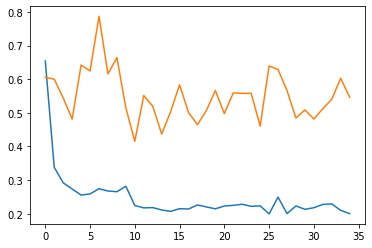

In [20]:
import matplotlib.pyplot as plt
plt.plot(train_losses)
plt.plot(val_losses)